<a href="https://colab.research.google.com/github/plaisier-lab/python3_courses/blob/main/DataIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>BME 210:  Week 15 - Data Integration</h1>

#<h2>Background</h2>
<p>Most work in data anlaysis involves data integration of large tables to identify intersections and the significance of the overlaps. The data we use to integrate determines the meaning of our anlayses. For example, in this weeks programming assignment you will integrate data from two experimental sources that descibe which genes transcription factors regulate. Transcritpion factors or TFs are proteins which bind to the DNA and change the expression pattern of RNA from a genomic locus or gene.</p>

<img src='https://ib.bioninja.com.au/_Media/gene-expression_med.jpeg'>

<p><b>Figure 1.</b> In this figure from BioNinja the TFs are the yellow and red proteins, and the purple is the RNA polymerase. The expression of the gene can be modified up or down based on the function of the TF.</p>

##<h3>Sources of data</h3>
<p>For these analyses we will be integrating two different experimental types.</p>

###<h4>Differential expression analysis</h4>
First, experimental quantification of RNA expression after TF over-expression. This identifies genes that change expression in the presence of the TF. The change in gene expresssion depends on the mechanism of interaction with teh target gene promoter with the TF. TFs can function as an acivator (increases expression of target) or repressor (decreases expression of target). The goal of TF over-expression is to identify statistically differentially expressed genes. We do this using differential expression anlaysis which is best exemplified by the figure below:</p>

<center><img src='https://www.htgmolecular.com/assets/htg/imgs/volcano_plot.JPG' width='600'></center>

###<h4>Direct TF binding to promoter via ChIP-seq</h4>
<p>The second data type is direct TF binding using ChIP-seq using an antibody for the TF. In this experimental appraoch the TF is crosslinked to the DNA, the DNA is sheared into smaller fragments, the antibody is used to pulldown fragments bound by the TF, the TF is released, adapters are ligated, and the DNA fragments are sequenced to identify the regions bound by the TF. This is shown in the figure below:</p>

<center><img src='https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fnmeth.f.247/MediaObjects/41592_2009_Article_BFnmethf247_Fig1_HTML.jpg' width='400'></center>

###<h4>Integrating the data types</h4>

<p>It should be noted that differential expression analysis does not give us direct targets, and ChIP-seq gives us direct targets but does not tell us if the binding leads to differential expression. Thus integrating these two methods can provide us with a list of target genes that are bound by the TF and this binding leads to differential expression. These genes should hopefully have a significant overlap between these two data sources, otherwise we know there is a problem somewhere either experimentally or data analysis.</p>

#<h2>Outline of anlaysis</h2>

<ol>
    <li>Download data</li>
    <li>Load RNA-seq and get gene list</li>
    <li>Load ChIP-seq and get gene list</li>
    <li>Convert into same gene identifiers if necessary</li>
    <li>Find overlap</li>
    <li>Make Venn diagram</li>
</ol>

<p>These analyses are based off the studies of the TF USF1 from <a href='https://pubmed.ncbi.nlm.nih.gov/19750004/'>Plaisier et al., 2009</a>. In this work they show that USF1 over-expression (OE) genes overlap with ChIP-seq target genes for USF1.</p>

<p><b>Goal of these studies</b>: We will repeat the analysis between USF1 OE differentially expressed genes (DEGs) and ChIP-seq target genes with newer data.</p>

#<h2>0. Install packages</h2>

<p>Two packages are required for this analysis pipeline:</p>
<ol>
    <li><a href='https://pypi.org/project/matplotlib-venn/'>matplot-venn</a> - package to make Venn diagrams that show the overlap between two or more lists of objects of a similar type.</li>
    <li><a href='https://docs.mygene.info/projects/mygene-py/en/latest/'>mygene</a> - package to convert gene IDs between types.</li>
</ol>

In [1]:
# Install packages needed to conduct analyses
!pip install matplotlib-venn
!pip install mygene

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##<h4>0.1 Load up packages</h4>

<p>Need a suite of different pacakges that provide the functionality to conduct the analyses in this pipeline:</p>

<ul>
  <b>Data import</b>
  <li><a href='https://pandas.pydata.org/pandas-docs/stable/reference/index.html'>pandas</a></li>
  <li><a href='https://numpy.org/doc/stable/reference/c-api/index.html'>numpy</a></li>
  <b>Gene ID conversion</b>
  <li><a href='https://docs.mygene.info/projects/mygene-py/en/latest/'>mygene</a></li>
  <b>Plot Venn diagram</b>
  <li><a href='https://matplotlib.org/stable/api/index.html'>matplotlib</a></li>
  <li><a href='https://pypi.org/project/matplotlib-venn/'>matplotlib_venn</a></li>
</ul>

In [2]:
## Import packages for anlaysis

# For data import and manipulation
import pandas as pd
import numpy as np
import json

# For gene ID conversions
import mygene
mg = mygene.MyGeneInfo()

# For plotting Venn diagrams
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3

# 1. Download Data

Data in this case was processed through various pipelines to generate a gene list of RNA-seq differentially expressed genes, Encode TF targets, and previously known USF1 target genes.

In [3]:
!gdown 1-kc-J6Y_Rg7974D6JB5glMxRgUA2kJlM
!gdown 1O6pONtylXlqhzC2Nqr5utWzliiC7L-6z
#!gdown 1S1roy77HgeOAZSiVyHWrKRIoliIbdimw
!ls


Downloading...
From: https://drive.google.com/uc?id=1-kc-J6Y_Rg7974D6JB5glMxRgUA2kJlM
To: /content/USF1_OE_DEGs.csv
100% 154k/154k [00:00<00:00, 82.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O6pONtylXlqhzC2Nqr5utWzliiC7L-6z
To: /content/ENCODE_TF_targests_USF1.json
100% 977k/977k [00:00<00:00, 114MB/s]
ENCODE_TF_targests_USF1.json	  ENCODE_TF_targests_USF1.txt  USF1_OE_DEGs.csv
ENCODE_TF_targests_USF1.json.txt  sample_data


# 2. Load RNA-seq and get gene list

##2.1 Look at RNA-seq DEGs file (USF1_OE_DEGs.csv)

<p>Take a look at the file in Sublime text editor:</p>

<center><img src='https://lh5.googleusercontent.com/2Ss-jNZRgE6vhp1rHCQ1QoQHyICB3QS1lYV561E_SkPT4iqrY4W7a2zfeOYTNjZP-vE=w2400' width='600'></center>

##<h4>2.2 Ask our standard set of questions</h4>

<ul>
  <li>Q: What is the file extension? A: csv</li>
  <li>Q: What is the file delimiter? A: commas</li>
  <li>Q: Does the file have a header? A: yes</li>
  <li>Q: Is there a unique index? A: yes</li>
  <li>Q: Which column should we use as a unique index? A: 0</li>
</ul>

##<h4>2.3 Load file</h4>

<p>Now we are ready to load up the file.</p>

In [19]:
# Load up RNA-seq DEGs
degs_df = pd.read_csv('USF1_OE_DEGs.csv', header = 0, index_col = 0)
print(degs_df.shape)
print(degs_df.columns)
print(degs_df.index)

(3353, 5)
Index(['EntrezID', 'Fold-Change', 'T Statistic', 'DegreesofFreedom',
       'P-value'],
      dtype='object')
Index(['218488_at', '212209_at', '221816_s_at', '219257_s_at', '203701_s_at',
       '223441_at', '233329_s_at', '205548_s_at', '205935_at', '211774_s_at',
       ...
       '218423_x_at', '206864_s_at', '205986_at', '208066_s_at', '217028_at',
       '225269_s_at', '217886_at', '238597_at', '218365_s_at', '239277_at'],
      dtype='object', length=3353)


##<h4>2.4 Further processing to extract Entrez IDs</h4>

<p>Now we need to dig into the pands DataFrame to extract the Entrez gene IDs. Very simple using column ID. Going to save it into a list because it is only a single value per entry we are saving.</p>

In [28]:
degs = list(degs_df['EntrezID'].dropna())

##<h4>2.5 How many genes? Any duplicates?</h4>

<p>Because there are duplicates we remove them using a nifty trick of converting to a set and then back into a list. The set conversion removes any duplicates as a set can only contain unique values.</p>

In [29]:
print(len(degs))
print(len(set(degs))) # duplicates!

# Get rid of duplicates
degs = list(set(degs))

3269
2803


# 3. Load ChIP-seq and get gene list

##<h4>3.1 Look at ChIP-seq target gene file (.json)</h4>

<p>Take a look at the file in Sublime text editor:</p>

<center><img src='https://lh5.googleusercontent.com/FLbCwR26l6rvQ_01Yw5VE43beCUGgPGltvuPnzbuAqia9a4MPeRMXUVL283BF71LrGo=w2400' width='600'></center>

##<h4>3.2 Ask our standard set of questions</h4>

<ul>
  <li>Q: What is the file extension? A: json</li>
  Full stop!
</ul>

##<h4>3.3 Load file</h4>

<p>Because this is a json file we need to use the json package to load up the file.</p>

In [30]:
with open('ENCODE_TF_targests_USF1.json','r') as json_file:
     chip_targets_json = json.load(json_file)

print(chip_targets_json.keys())

dict_keys(['attribute', 'dataset', 'associations'])


##<h4>3.4 Further processing to extract gene symbols</h4>

<p>Now we need to dig into the json data structure to extract the gene symbols. The gene symbols are under the 'associations' key, and then for each entry under the 'gene' and 'symbol' key. Going to save it into a list because it is only a single value per entry we are saving.</p>

In [31]:
chip_targets = []
for entry in chip_targets_json['associations']:
    chip_targets.append(entry['gene']['symbol'])

##<h4>3.5 How many genes? Any duplicates?</h4>

In [32]:
print(len(chip_targets))
print(len(set(chip_targets))) # no duplicates!

12305
12305


# 4. Convert into same gene identifiers if necessary

##<h4>4.1 Check if gene identifiers have same type</h4>

<p>First print out degs:</p>

In [34]:
print(degs[0:5])


[8195.0, 81928.0, 90120.0, 81930.0, 9.0]


Next print out chip_targets:

In [35]:
print(chip_targets[0:5])

['SLC26A1', 'SLC5A8', 'ST20-MTHFS', 'P2RX5', 'ZNF740']


<p>The degs are numbers (Entrez IDs) and chip_targets are text (symbols). They will not overlap because the genes are called differently in each gene identifier type. Thus we need to consolidate them both to the same gene identifier type.</p>

##<h4>4.2 Convert both to Entrez ID type</h4>

<p>Easiest approach is to choose one of the types as the final gene identifier type. We don't want to choose gene symbol as they can change over time as the gene name evolves, and also can <a href='https://ncbiinsights.ncbi.nlm.nih.gov/2016/11/07/clearing-up-confusion-with-human-gene-symbols-names-using-ncbi-gene-data/'>cause problems when loaded into Excel</a>.</p>

<p>This means we choose to convert the gene symbols in the chip_targets into Entrez IDs. And the easiest way to do this is using the mygene package.</p>

In [39]:
converted = mg.querymany(chip_targets, scopes='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12305...done.
Finished.
146 input query terms found dup hits:
	[('MRPL45P2', 2), ('REXO1L2P', 2), ('GLRA4', 2), ('FAM224A', 2), ('ZNF826P', 2), ('SNORD58C', 2), ('
881 input query terms found no hit:
	['MESDC2', 'NAT6', 'H2AFZ', 'HIST2H2AB', 'METTL12', 'C19ORF80', 'NGFRAP1', 'SEPT11', 'H2AFX', 'C4ORF
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [43]:
chip_targets_entrez = list(converted['entrezgene'].dropna())
print(chip_targets_entrez[0:5])

['10861', '160728', '100528021', '5026', '283337']
[10861.0, 160728.0, 100528021.0, 5026.0, 283337.0]


<p>One last thing. The degs Entrez IDs are in float format. And ours are in string. So we need to convert them to be comparable.</p>

In [44]:
chip_targets_entrez_float = []
for egid in chip_targets_entrez:
    chip_targets_entrez_float.append(float(egid))

print(chip_targets_entrez_float[0:5])

[10861.0, 160728.0, 100528021.0, 5026.0, 283337.0]


#5. Find overlap

##<h4>5.1 Find overlap between degs and chip_targets.</h4>

<p>This is very simple using set theory, which we can do if we convert one of the lists to a set.</p>

In [46]:
# Convert degs to set and intersect with chip_targets
overlap = set(degs).intersection(chip_targets_entrez_float)
print(list(overlap)[0:5])
print(len(overlap))
print(len(degs))
print(len(chip_targets_entrez_float))

[8195.0, 81928.0, 81930.0, 22.0, 23.0]
2020
2803
11426


##<h4>5.2 (optional) Significance of overlap</h4>

<p>The significance of the overlap can be determined using the hypergeometric enrichment analysis.</p>
<ul>
    <li><a href='https://docs.scipy.org/doc/scipy/tutorial/stats/discrete_hypergeom.html#:~:text=Hypergeometric%20Distribution%20%E2%80%94%20SciPy%20v1.9.3%20Manual%20Hypergeometric%20Distribution,number%20of%20%E2%80%9Cgood%20%E2%80%9Cobjects%20in%20the%20total%20population.'>scipy.stats.hypergeom</a></li>
</ul>

<p>The survival function (hypergeom.sf) sums the likelihood of greater than or equal to the observed overlap.</p>

In [48]:
from scipy.stats import hypergeom
k = len(overlap)
M = 20000
n = len(degs)
N = len(chip_targets_entrez_float)
p_value = hypergeom.sf(k, M, n, N)
print([k,M,n,N,p_value])

[2020, 20000, 2803, 11426, 1.2726667830487699e-69]


##<h4>5.3 (optional) Interpreation of p-value</h4>
<p>This p-value indicates that is is very unlikely we would have observed this overlap by chance alone.</p>

#6. Make Venn diagram

##<h4>6.1 Make a Venn diagram of DEGs and ChIP-seq target genes</h4>

<p></p>

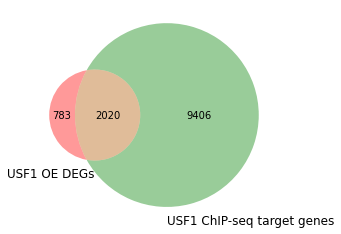

In [51]:
venn2([set(degs), set(chip_targets_entrez_float)], ('USF1 OE DEGs','USF1 ChIP-seq target genes'))
plt.show()

##<h4>6.2 Interpretation of plot</h4>

<p>A majority of differentially expressed genes are also direct targets of USF1. This suggests that the over-expresion was successful and that the ChIP-seq experiment was as well. We use the gut check to ensure that our studies are solid. And then the 2,020 genes would be our direct targets that change significantly with changes in USF1 expression.</p>